In [2]:
import pandas as pd
import numpy as np



# from scipy.stats import spearmanr, rankdata
# from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold

In [3]:
def load_data(path):

    files = os.listdir(f'{path}\\img\\data\\')
    image = np.empty((len(files), 50, 50, 1))
    sample = []
    id = []
    for i in range(len(files)):
        if files[i].split('.')[1] == 'txt':
            id.append(i)
            data = pd.read_csv(f'{path}\\img\\data\\{files[i]}', sep='\t', engine='c', na_values=['na', '-', ''], header=None, index_col=None)
            image[i, :, :, 0] = data.values
            sample.append(files[i].split('.txt')[0])
    image = image[id, :, :, :]

    return image

In [4]:
def top_n_miRNA(input_data, n):
    temp_df = input_data.copy()
    temp_df['sums'] = (temp_df.iloc[:,1:].sum(axis = 1))
    temp_df = temp_df.sort_values(by='sums', ascending=False)
    return temp_df.iloc[0:n,0:-1]


In [68]:
# def train_test_data(data_main, test_per = 0.2):
#     rand_test_index= np.random.randint(0, data_main.shape[0], np.int64(data_main.shape[0]*test_per))
#     test_data = data_main[rand_test_index]
#     train_data = np.delete(data_main, rand_test_index, axis = 0)

#     return train_data, test_data, rand_test_index


# train_data, test_data, test_indx = train_test_data(all_data, test_per=0.1)

In [5]:
# data_path = '..\\Results\\Table_To_Image_Conversion\\Test_1\\data'
data_path = "D:\\Research\\data\\processed_dataset" #lab

# tissue_type = 'liver'
# tissue_type = 'pancreas'
# tissue_type = 'kidney'
tissue_type = 'heart'
# tissue_type = 'brain_myeloid'


In [32]:
all_data = load_data(path = f'{data_path}\\{tissue_type}')
all_data.shape

(6002, 50, 50, 1)

In [8]:
all_data = all_data/255

In [7]:
y_target = pd.read_csv(f'{data_path}\\{tissue_type}\\miRNA_bulk.csv')
y_target = y_target.drop('Unnamed: 0',axis=1)

# y_target = y_target.iloc[:,1:].drop(y_target.index[(y_target.iloc[:,1:].sum(axis = 1) < 1000)]).T


y_target.shape

# y_target = y_target.iloc[:,1:].T
# y_target = y_target.values
# y_target

# y_target['sums'] = (y_target.iloc[:,1:].sum(axis = 1))
# y_target.sort_values(by='sums', ascending=False)
# y_target.iloc[0:50,0:-1]


(224, 6003)

In [28]:
top_miRNAs = top_n_miRNA(y_target, 1)
top_miRNAs = top_miRNAs.iloc[:,1:].T
top_miRNAs = top_miRNAs.rename(columns={top_miRNAs.columns[0]: "amount"})


In [41]:
def balance_data(x_tn, y_lb):
    if(x_tn.shape[0]==y_lb.shape[0]):
        
    else:
        print('Dataset Shape did not match!!')

In [49]:
# balance_data(all_data,top_miRNAs)
top_miRNAs.shape[0] - top_miRNAs.amount.value_counts()[0]

794

In [297]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(top_miRNAs.iloc[:,1:])

# top_miRNAs = preprocessing.MinMaxScaler(top_miRNAs.iloc[:,1:].T)
# top_miRNAs
# top_miRNAs = top_miRNAs.iloc[:,1:].values.T

In [355]:
# top_miRNAs = top_miRNAs.T
# bins = [0, 99, 199, 299, 399, 499, 599, 699, 799, 899, 999]
# labels = ['J', 'I', 'H', 'G', 'F', 'E', 'D','C', 'B', 'A',]

bins = [0, 1, 19, 29, 39, 49, 59, 69, 79, 89, 99, 999]
labels = ['K','J', 'I', 'H', 'G', 'F', 'E', 'D','C', 'B', 'A',]

top_miRNAs['grade'] = pd.cut(x = top_miRNAs['amount'], bins = bins, labels = labels, include_lowest = True)

In [390]:
top_miRNAs.sort_values(by='amount')


,amount
O5.MAA000570.3_8_M.1.1,0
A11.B003278.3_38_F.1.1,0
H13.B003278.3_38_F.1.1,0
L6.B003278.3_38_F.1.1,0
A20.B003278.3_38_F.1.1,0
...,...
M10.B003279.3_38_F.1.1,183
J8.MAA000571.3_9_M.1.1,190
G3.B003279.3_38_F.1.1,223
A18.B003279.3_38_F.1.1,228


In [389]:
top_miRNAs['amount'].value_counts().mean()


36.91472868217054

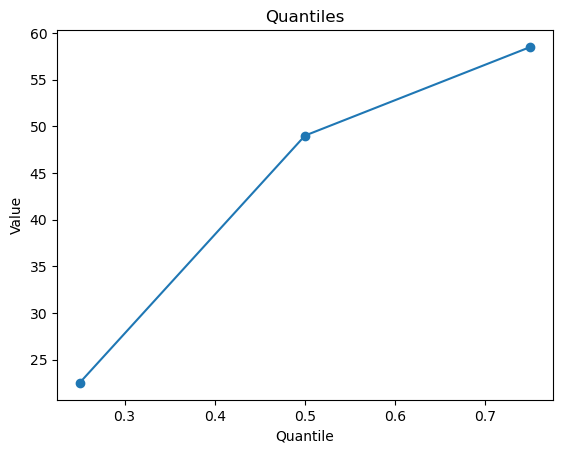

In [372]:
quantiles  = top_miRNAs['grade'].value_counts().quantile([0.25, 0.5, 0.75])
quantiles.plot(marker='o')
plt.xlabel('Quantile')
plt.ylabel('Value')
plt.title('Quantiles')
plt.show()

<AxesSubplot:ylabel='Frequency'>

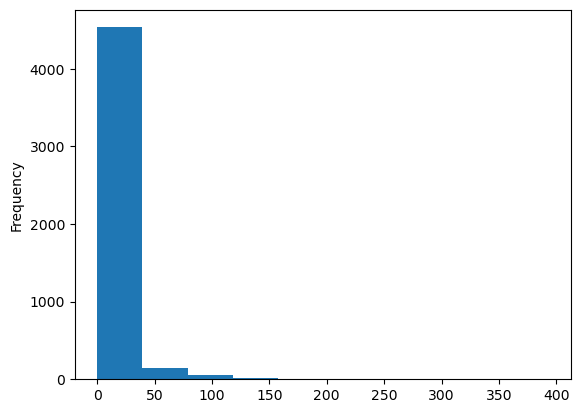

In [382]:
# top_miRNAs['grade'].value_counts().plot.bar()
top_miRNAs['count'].plot(kind='hist')


In [214]:
# X_train, X_test, y_train, y_test = train_test_split(all_data, y_target, test_size=0.1, random_state=5)

# print(f'X_train: {X_train.shape}')
# print(f'X_test: {X_test.shape}')
# print(f'y_train: {y_train.shape}')
# print(f'y_test: {y_test.shape}')



None


In [ ]:
for i in range(top_miRNAs.shape[0]):
    print(top_miRNAs[i])


In [99]:

# def runCNN(train_x_input, train_y_input, val_x, val_y, epoch_num = 10, batch_num = 32):
# # Define the model
#     model = keras.Sequential()

#     # Add the layers to the model
#     model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
#     model.add(keras.layers.BatchNormalization())

#     # Flatten the output before passing it to the fully connected layers
#     model.add(keras.layers.Flatten())

#     # Add fully connected layers
#     model.add(keras.layers.Dense(128, activation='relu'))
#     model.add(keras.layers.Dense(64, activation='relu'))
#     model.add(keras.layers.Dense(train_y_input.shape[1], activation='softmax'))

#     # Compile the model
#     model.compile(optimizer='Adam',
#                 loss='mse',
#                 metrics=['accuracy'])

#     # Print the model summary
#     print(model.summary())

#     history = model.fit(train_x_input, train_y_input, epochs=epoch_num, batch_size=batch_num, validation_data = (val_x, val_y))

#     return model, history


In [115]:
def plot_history(his, tissue_type = ''):
    plt.plot(his.history['accuracy'])
    plt.plot(his.history['val_accuracy'])
    plt.title(f'Model Accuracy: {tissue_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title(f'Model Loss: {tissue_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [144]:
model = keras.Sequential()

# Add the layers to the model
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(all_data.shape[1], all_data.shape[2], all_data.shape[3])))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())

# Flatten the output before passing it to the fully connected layers
model.add(keras.layers.Flatten())

# Add fully connected layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(top_miRNAs.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='Adam',
            loss='mse',
            metrics=['accuracy'])

# Print the model summary
print(model.summary())




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_19 (Bat  (None, 22, 22, 32)       128       
 chNormalization)                                                
                                                      

In [89]:
# model_pan, history_pan = runCNN(train_x_input=X_train, train_y_input=y_train, epoch_num=100, val_x=X_test,  val_y=y_test)

In [100]:
# plot_history(history_pan, tissue_type=tissue_type)

In [145]:
num_folds = 5
fold_scores = []
epoch_num = 50
batch_num = 32

kfold = KFold(n_splits=num_folds, shuffle=True)



for train_indices, test_indices in kfold.split(all_data):
    # print('Train: %s | test: %s' % (train_indices, test_indices))


    X_train, X_val = all_data[train_indices], all_data[test_indices]
    y_train, y_val = top_miRNAs[train_indices], top_miRNAs[test_indices]

    history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_data = (X_val, y_val))

    _, score = model.evaluate(X_val, y_val)
    fold_scores.append(score)


Epoch 1/50
151/151 [==============================] - 3s 20ms/step - loss: 2227.1716 - accuracy: 0.0092 - val_loss: 1976.4580 - val_accuracy: 0.0042
Epoch 2/50
151/151 [==============================] - 4s 29ms/step - loss: 2227.1716 - accuracy: 0.0092 - val_loss: 1976.4580 - val_accuracy: 0.0042
Epoch 3/50
151/151 [==============================] - 2s 16ms/step - loss: 2227.1716 - accuracy: 0.0092 - val_loss: 1976.4580 - val_accuracy: 0.0042
Epoch 4/50
151/151 [==============================] - 2s 16ms/step - loss: 2227.1716 - accuracy: 0.0092 - val_loss: 1976.4580 - val_accuracy: 0.0042
Epoch 5/50
151/151 [==============================] - 2s 16ms/step - loss: 2227.1716 - accuracy: 0.0092 - val_loss: 1976.4580 - val_accuracy: 0.0042
Epoch 6/50
151/151 [==============================] - 2s 16ms/step - loss: 2227.1716 - accuracy: 0.0092 - val_loss: 1976.4580 - val_accuracy: 0.0042
Epoch 7/50
 47/151 [========>.....................] - ETA: 1s - loss: 1893.7600 - accuracy: 0.0066

KeyboardInterrupt: 

In [59]:
fold_scores

[0.09741881489753723,
 0.0741049125790596,
 0.11916666477918625,
 0.1341666728258133,
 0.33500000834465027]